# Fraud Detection in Electricity and Gas Consumption Challenge



This notebook covers:
- EDA
- Baseline model
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Data Understanding

In [107]:
df_client.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


-> 6 % Fraud

In [98]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [2]:
import pandas as pd
df_client = pd.read_csv('data/client_train.csv')
df_client.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [3]:
df_invoice = pd.read_csv('data/invoice_train.csv')
df_invoice.head()

C:\Users\thoma\AppData\Local\Temp\ipykernel_9376\4194328248.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_invoice = pd.read_csv('data/invoice_train.csv')


,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [ ]:
# Die 'creation date'-Spalte in ein Datumsobjekt umwandeln
df_client['creation_date'] = pd.to_datetime(df_client['creation_date'], format='%d/%m/%Y')

# Eine neue Spalte 'year' erstellen, die das Jahr aus dem Datum enthält
df_client['year'] = df_client['creation_date'].dt.year

In [9]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [10]:
df_client.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [25]:
unique_catg = df_client['client_catg'].unique()
unique_catg

array([11, 12, 51], dtype=int64)

In [20]:
unique_districts = df_client['disrict'].unique()
unique_districts

array([60, 69, 62, 63], dtype=int64)

In [21]:
unique_regions = df_client['region'].unique()
unique_regions

array([101, 107, 301, 105, 303, 103, 309, 311, 304, 104, 312, 305, 306,
       308, 372, 307, 313, 310, 371, 302, 106, 379, 399, 206, 199],
      dtype=int64)

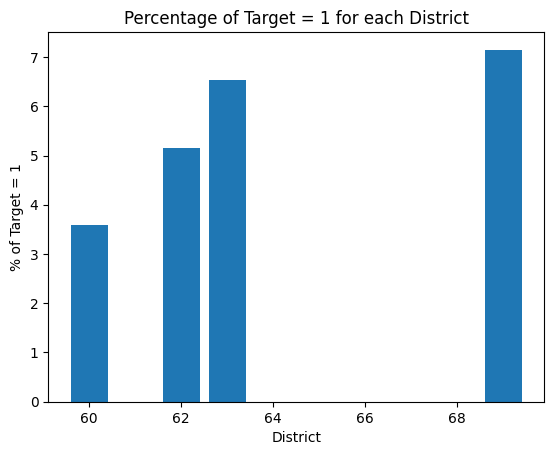

In [22]:
import pandas as pd
import matplotlib.pyplot as plt



# Gruppieren nach 'district' und Berechnen des Prozentsatzes von 'target' == 1
grouped = df_client.groupby('disrict')['target'].mean() * 100

# Plot erstellen
plt.bar(grouped.index, grouped.values)
plt.xlabel('District')
plt.ylabel('% of Target = 1')
plt.title('Percentage of Target = 1 for each District')
plt.show()


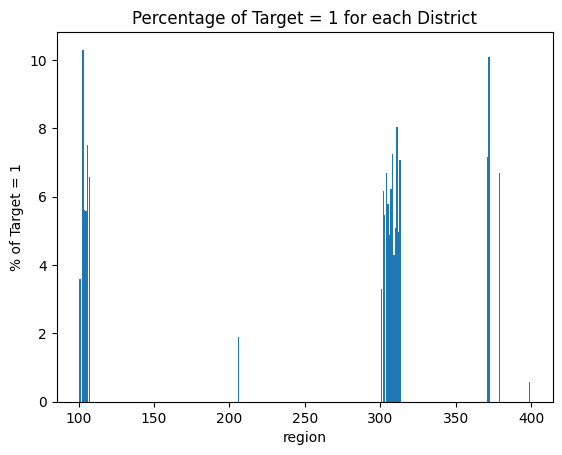

In [24]:
import pandas as pd
import matplotlib.pyplot as plt



# Gruppieren nach 'district' und Berechnen des Prozentsatzes von 'target' == 1
grouped = df_client.groupby('region')['target'].mean() * 100

# Plot erstellen
plt.bar(grouped.index, grouped.values)
plt.xlabel('region')
plt.ylabel('% of Target = 1')
plt.title('Percentage of Target = 1 for each District')
plt.show()

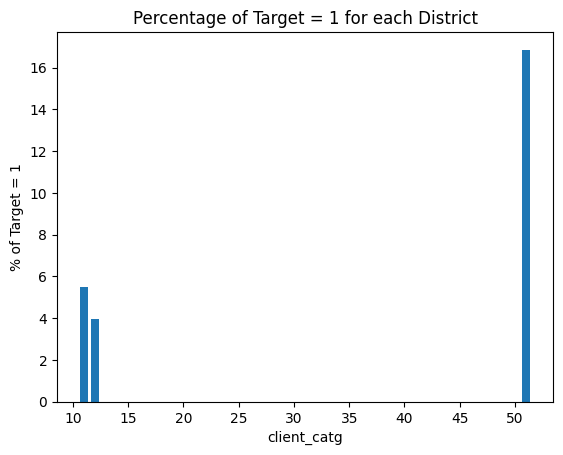

In [26]:
import pandas as pd
import matplotlib.pyplot as plt



# Gruppieren nach 'district' und Berechnen des Prozentsatzes von 'target' == 1
grouped = df_client.groupby('client_catg')['target'].mean() * 100

# Plot erstellen
plt.bar(grouped.index, grouped.values)
plt.xlabel('client_catg')
plt.ylabel('% of Target = 1')
plt.title('Percentage of Target = 1 for each District')
plt.show()

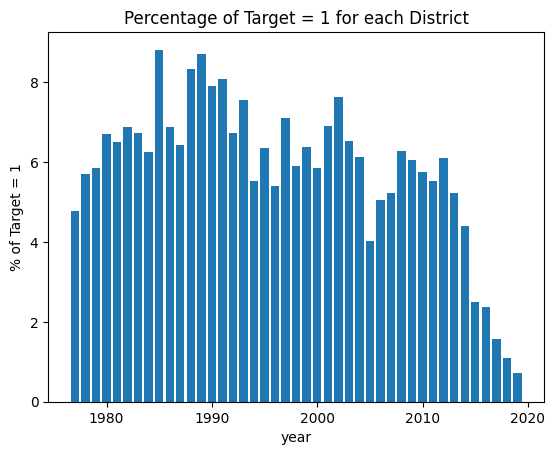

In [29]:
import pandas as pd
import matplotlib.pyplot as plt



# Gruppieren nach 'district' und Berechnen des Prozentsatzes von 'target' == 1
grouped = df_client.groupby('year')['target'].mean() * 100

# Plot erstellen
plt.bar(grouped.index, grouped.values)
plt.xlabel('year')
plt.ylabel('% of Target = 1')
plt.title('Percentage of Target = 1 for each District')
plt.show()

In [12]:
df_invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [13]:
df_invoice.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [4]:
# Left Join durchführen
df_merged_invoice_client = df_client.merge(df_invoice, on='client_id', how='left')

In [91]:
df_merged_invoice_client.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type', 'invoice_date_new',
       'index_diff', 'index_diff_Month', 'year_invoice', 'invoice_year'],
      dtype='object')

In [51]:
import pandas as pd

# Annahme: df_merged_invoice_client ist der DataFrame mit den Daten
# Angenommen, 'old_index' und 'new_index' sind numerische Spalten (z. B. Ganzzahlen)

# Erstelle eine neue Spalte 'index_diff' mit der Differenz zwischen 'new_index' und 'old_index'
df_merged_invoice_client['index_diff'] = df_merged_invoice_client['new_index'] - df_merged_invoice_client['old_index']





In [57]:
# Konvertiere die 'invoice_date' Spalte in das Datumsformat
df_merged_invoice_client['invoice_date'] = pd.to_datetime(df_merged_invoice_client['invoice_date'])

# Erstelle eine neue Spalte 'year_invoice', die nur das Jahr aus der 'invoice_date' Spalte enthält
df_merged_invoice_client['year_invoice'] = df_merged_invoice_client['invoice_date'].dt.year

# Consumption on monthly basis

In [54]:
df_merged_invoice_client['index_diff_Month'] = df_merged_invoice_client['index_diff'] / df_merged_invoice_client['months_number']

In [59]:
# Extrahiere das Jahr aus der 'invoice_date' Spalte in eine neue 'invoice_year' Spalte
df_merged_invoice_client['invoice_year'] = df_merged_invoice_client['invoice_date'].dt.year

# Gruppiere den DataFrame nach der 'invoice_year' Spalte und berechne den Durchschnitt für 'index_diff_Month'
aggregated_data = df_merged_invoice_client.groupby('invoice_year')['index_diff_Month'].mean().reset_index()

In [83]:
# Gruppiere den DataFrame nach der 'invoice_year' Spalte und berechne den Durchschnitt und die Standardabweichung für 'index_diff_Month'
aggregated_data = df_merged_invoice_client.groupby('invoice_year')['index_diff_Month'].agg(['mean', 'std', 'max', 'min', lambda x: x.quantile(0.23),lambda x: x.quantile(0.50),lambda x: x.quantile(0.75)]).reset_index()

# Umbenennen der neuen Spalten für die bessere Darstellung
## Umbenennen der neuen Spalten für die bessere Darstellung
# Umbenennen der neuen Spalten für die bessere Darstellung
aggregated_data.rename(columns={'mean': 'index_diff_Month_mean', 'std': 'index_diff_Month_std',
                                'max': 'index_diff_Month_max', 'min': 'index_diff_Month_min',
                                '<lambda_0>': '25_percentile', '<lambda_1>': '50_percentile', '<lambda_2>': '75_percentile'}, inplace=True)

In [86]:
aggregated_data

,invoice_year,index_diff_Month_mean,index_diff_Month_std,index_diff_Month_max,index_diff_Month_min,25_percentile,50_percentile,75_percentile
0,1977,41.200000,43.409996,139.500000,0.00,4.555000,32.375000,58.9375
1,1978,40.406250,69.683025,466.000000,0.00,0.000000,22.500000,40.2500
2,1979,308.205911,936.545236,6321.500000,0.00,7.220000,32.000000,141.0000
3,1980,96.340717,206.298620,1322.500000,0.00,12.055000,30.250000,71.3750
4,1981,108.017764,428.057013,3712.000000,0.00,4.070000,25.166667,61.0000
5,1982,128.794459,358.264357,3101.000000,0.00,2.500000,32.000000,97.0000
6,1983,114.822824,286.553430,2016.500000,0.00,4.660000,37.500000,90.7500
7,1984,69.773433,106.480191,1225.500000,0.00,21.176667,49.750000,83.6250
8,1985,91.106164,202.659540,1680.500000,0.00,12.550000,44.000000,86.5000
9,1986,84.786791,179.003674,2476.500000,0.00,3.000000,40.916667,85.5000


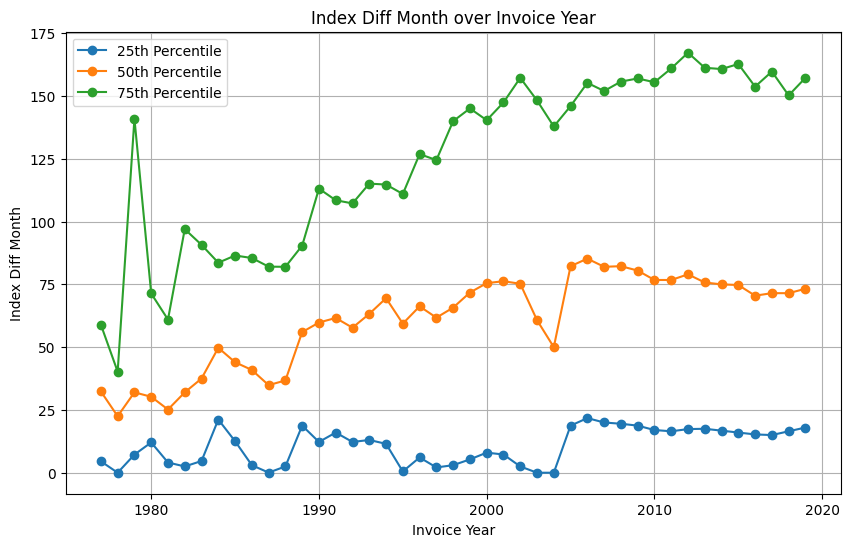

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Annahme: aggregated_data ist der DataFrame mit den aggregierten Daten
# Angenommen, aggregated_data enthält die Spalten 'invoice_year', 'index_diff_Month_mean', '25_percentile', '50_percentile' und '75_percentile'

# Plot erstellen
plt.figure(figsize=(10, 6))

# Linienplot für 'index_diff_Month_mean'
#plt.plot(aggregated_data['invoice_year'], aggregated_data['index_diff_Month_mean'], label='Mean', marker='o')

# Linienplot für '25_percentile'
plt.plot(aggregated_data['invoice_year'], aggregated_data['25_percentile'], label='25th Percentile', marker='o')

# Linienplot für '50_percentile'
plt.plot(aggregated_data['invoice_year'], aggregated_data['50_percentile'], label='50th Percentile', marker='o')

# Linienplot für '75_percentile'
plt.plot(aggregated_data['invoice_year'], aggregated_data['75_percentile'], label='75th Percentile', marker='o')

plt.xlabel('Invoice Year')
plt.ylabel('Index Diff Month')
plt.title('Index Diff Month over Invoice Year')
plt.legend()
plt.grid(True)
plt.show()


In [92]:
import pandas as pd

# Annahme: df_merged_invoice_client ist der DataFrame mit den Daten
# Angenommen, df_merged_invoice_client enthält die Spalten 'invoice_date' und 'index_diff_Month'
# Annahme: aggregated_data ist der DataFrame mit den aggregierten Daten
# Angenommen, aggregated_data enthält die Spalten 'invoice_year', '25_percentile'

# Konvertiere die 'invoice_date' Spalte in das Datumsformat (falls noch nicht geschehen)
df_merged_invoice_client['invoice_date'] = pd.to_datetime(df_merged_invoice_client['invoice_date'])

# Extrahiere das Jahr aus der 'invoice_date' Spalte in eine neue 'invoice_year' Spalte
df_merged_invoice_client['invoice_year'] = df_merged_invoice_client['invoice_date'].dt.year

# Funktion zum Vergleichen und Zuweisen der Werte
def compare_and_assign(row):
    year = row['invoice_year']
    value = row['index_diff_Month']
    threshold = aggregated_data.loc[aggregated_data['invoice_year'] == year, '25_percentile'].iloc[0]
    return 1 if value < threshold else 0

# Wende die Funktion auf den DataFrame an und erstelle die neue Spalte 'compare_result'
df_merged_invoice_client['compare_result'] = df_merged_invoice_client.apply(compare_and_assign, axis=1)




In [93]:
df_merged_invoice_client.head(5)

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,old_index,new_index,months_number,counter_type,invoice_date_new,index_diff,index_diff_Month,year_invoice,invoice_year,compare_result
0,60,train_Client_0,11,101,31/12/1994,0.0,2014-03-24,11,1335667,0,...,14302,14384,4,ELEC,2014-03-24,82,20.500000,2014,2014,0
1,60,train_Client_0,11,101,31/12/1994,0.0,2013-03-29,11,1335667,0,...,12294,13678,4,ELEC,2013-03-29,1384,346.000000,2013,2013,0
2,60,train_Client_0,11,101,31/12/1994,0.0,2015-03-23,11,1335667,0,...,14624,14747,4,ELEC,2015-03-23,123,30.750000,2015,2015,0
3,60,train_Client_0,11,101,31/12/1994,0.0,2015-07-13,11,1335667,0,...,14747,14849,4,ELEC,2015-07-13,102,25.500000,2015,2015,0
4,60,train_Client_0,11,101,31/12/1994,0.0,2016-11-17,11,1335667,0,...,15066,15638,12,ELEC,2016-11-17,572,47.666667,2016,2016,0


In [ ]:
#Baseline model

Fraud (1) if energy consumption is lower than 25% in percentile

In [100]:
import pandas as pd

# Annahme: df_merged_invoice_client ist der DataFrame mit den Daten
# Angenommen, df_merged_invoice_client enthält die Spalten 'client_id' und 'compare_result'

# Gruppiere den DataFrame nach der 'client_id' und überprüfe, ob in der Spalte 'compare_result' mindestens ein Eintrag den Wert 1 hat
compare_target = df_merged_invoice_client.groupby('client_id')['compare_result'].max().reset_index()

# Umbenennen der Spalte 'compare_result' zu 'target'
compare_target.rename(columns={'compare_result': 'target_compare'}, inplace=True)

# Zeige das neue DataFrame compare_target an



In [101]:
import pandas as pd

# Annahme: df_merged_invoice_client ist der DataFrame mit den Daten
# Angenommen, df_merged_invoice_client enthält die Spalten 'client_id' und 'compare_result'

# Gruppiere den DataFrame nach der 'client_id' und überprüfe, ob in der Spalte 'compare_result' mindestens ein Eintrag den Wert 1 hat
compare_target = df_merged_invoice_client.groupby('client_id')['compare_result'].max().reset_index()

# Umbenennen der Spalte 'compare_result' zu 'target_compare'
compare_target.rename(columns={'compare_result': 'target_compare'}, inplace=True)

# Füge die Spalte 'target' aus df_merged_invoice_client in das DataFrame compare_target ein
compare_target = compare_target.merge(df_merged_invoice_client[['client_id', 'target']].drop_duplicates(), on='client_id', how='left')

# Zeige das neue DataFrame compare_target an
print(compare_target)


                 client_id  target_compare  target
0           train_Client_0               0     0.0
1           train_Client_1               0     0.0
2          train_Client_10               0     0.0
3         train_Client_100               1     0.0
4        train_Client_1000               0     0.0
...                    ...             ...     ...
135488  train_Client_99995               1     0.0
135489  train_Client_99996               1     0.0
135490  train_Client_99997               1     0.0
135491  train_Client_99998               0     0.0
135492  train_Client_99999               0     0.0

[135493 rows x 3 columns]


In [102]:
compare_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   client_id       135493 non-null  object 
 1   target_compare  135493 non-null  int64  
 2   target          135493 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ MB


In [104]:
# Erstelle die neue Spalte 'compare_result' basierend auf der Bedingung
compare_target['compare_result'] = compare_target.apply(lambda row: 1 if row['target_compare'] == row['target'] else 0, axis=1)

In [105]:
compare_target.head()

,client_id,target_compare,target,compare_result
0,train_Client_0,0,0.0,1
1,train_Client_1,0,0.0,1
2,train_Client_10,0,0.0,1
3,train_Client_100,1,0.0,0
4,train_Client_1000,0,0.0,1


In [106]:
percentage_1 = compare_target['compare_result'].mean() * 100

# Zeige den Anteil der 1 in Prozent an
print(f"Anteil der 1 in der Spalte 'compare_result': {percentage_1:.2f}%")

Anteil der 1 in der Spalte 'compare_result': 29.58%


# Outlook

- find out in which cases Fraud is wrongly assigned
- exclude cases where consumption is 0
- rise threshold
- why are there neg. consumptions
- apply decision trees or compare models
- try ensembling
-try NN

In [ ]:
#Part of EDA (up)

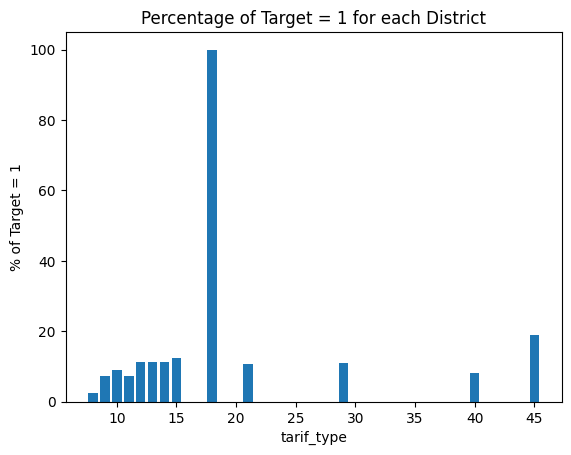

In [40]:
import pandas as pd
import matplotlib.pyplot as plt



# Gruppieren nach 'district' und Berechnen des Prozentsatzes von 'target' == 1
grouped = df_merged_invoice_client.groupby('tarif_type')['target'].mean() * 100

# Plot erstellen
plt.bar(grouped.index, grouped.values)
plt.xlabel('tarif_type')
plt.ylabel('% of Target = 1')
plt.title('Percentage of Target = 1 for each District')
plt.show()

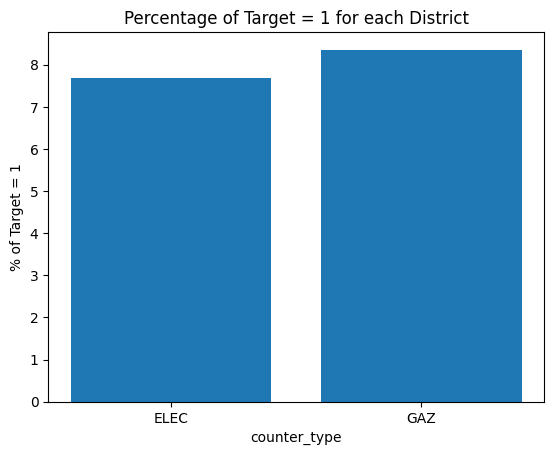

In [41]:
import pandas as pd
import matplotlib.pyplot as plt



# Gruppieren nach 'district' und Berechnen des Prozentsatzes von 'target' == 1
grouped = df_merged_invoice_client.groupby('counter_type')['target'].mean() * 100

# Plot erstellen
plt.bar(grouped.index, grouped.values)
plt.xlabel('counter_type')
plt.ylabel('% of Target = 1')
plt.title('Percentage of Target = 1 for each District')
plt.show()

counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 

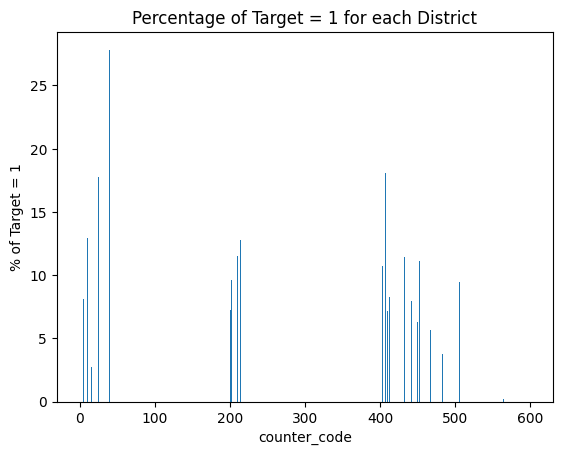

In [44]:
import pandas as pd
import matplotlib.pyplot as plt



# Gruppieren nach 'district' und Berechnen des Prozentsatzes von 'target' == 1
grouped = df_merged_invoice_client.groupby('counter_code')['target'].mean() * 100

# Plot erstellen
plt.bar(grouped.index, grouped.values)
plt.xlabel('counter_code')
plt.ylabel('% of Target = 1')
plt.title('Percentage of Target = 1 for each District')
plt.show()

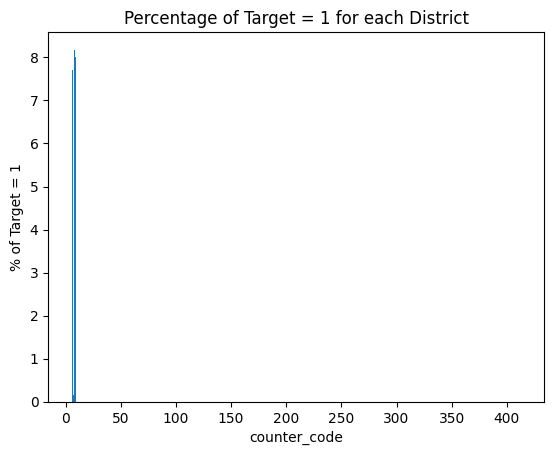

In [45]:
import pandas as pd
import matplotlib.pyplot as plt



# Gruppieren nach 'district' und Berechnen des Prozentsatzes von 'target' == 1
grouped = df_merged_invoice_client.groupby('reading_remarque')['target'].mean() * 100

# Plot erstellen
plt.bar(grouped.index, grouped.values)
plt.xlabel('reading_remarque')
plt.ylabel('% of Target = 1')
plt.title('Percentage of Target = 1 for each District')
plt.show()

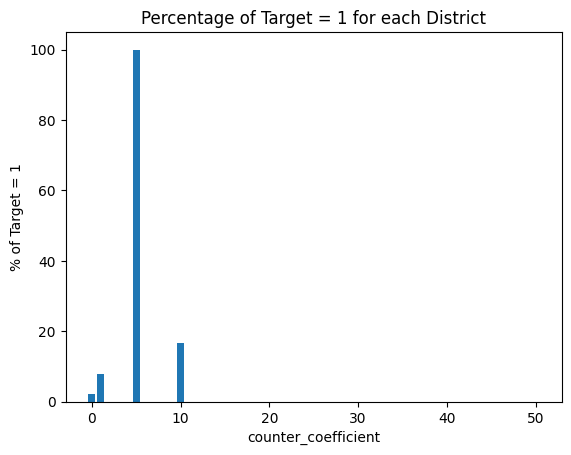

In [46]:
import pandas as pd
import matplotlib.pyplot as plt



# Gruppieren nach 'district' und Berechnen des Prozentsatzes von 'target' == 1
grouped = df_merged_invoice_client.groupby('counter_coefficient')['target'].mean() * 100

# Plot erstellen
plt.bar(grouped.index, grouped.values)
plt.xlabel('counter_coefficient')
plt.ylabel('% of Target = 1')
plt.title('Percentage of Target = 1 for each District')
plt.show()

In [19]:
grouped_data = df_merged_invoice_client.groupby(['client_id'])

In [25]:
df_merged_invoice_client['invoice_date'] = pd.to_datetime(df_merged_invoice_client['invoice_date'])
# Gruppiere die Daten nach client_id und Jahr

grouped_data = df_merged_invoice_client.groupby(['client_id', df_merged_invoice_client['invoice_date_new'].dt.year])

In [27]:
grouped_data[['client_id','invoice_date','months_number']].head(20)

,client_id,invoice_date,months_number
0,train_Client_0,2014-03-24,4
1,train_Client_0,2013-03-29,4
2,train_Client_0,2015-03-23,4
3,train_Client_0,2015-07-13,4
4,train_Client_0,2016-11-17,12
...,...,...,...
4476744,train_Client_99998,2005-08-19,8
4476745,train_Client_99998,2005-12-19,4
4476746,train_Client_99999,1996-09-25,4
4476747,train_Client_99999,1996-05-28,4


In [5]:
import pandas as pd

# Angenommen, df_merged_invoice_client ist der DataFrame mit den Daten
# client_id, invoice_date und Stromverbrauchsspalte (z. B. "Stromverbrauch")

# Konvertiere die invoice_date Spalte in das Datumsformat
df_merged_invoice_client['invoice_date_new'] = pd.to_datetime(df_merged_invoice_client['invoice_date'])
# Gruppiere die Daten nach client_id und Jahr

grouped_data = df_merged_invoice_client.groupby(['client_id', df_merged_invoice_client['invoice_date_new'].dt.year])

# Filtere nur die client_ids, die mindestens 12 Monate Daten haben
valid_client_ids = grouped_data.filter(lambda x: len(x) == 12)['client_id'].unique()

# Filtere die Daten, um nur die gültigen client_ids zu behalten
filtered_data = df_merged_invoice_client[df_merged_invoice_client['client_id'].isin(valid_client_ids)]

# Gruppiere die gefilterten Daten nach client_id und Jahr und berechne den durchschnittlichen Stromverbrauch für jedes Jahr
average_consumption_per_year = filtered_data.groupby([filtered_data['client_id'], filtered_data['invoice_date_new'].dt.year])['Stromverbrauch'].mean()

# Ergebnis anzeigen
print(average_consumption_per_year)



In [10]:
import pandas as pd

# Angenommen, df_merged_invoice_client ist der DataFrame mit den Daten
# client_id, invoice_date und Stromverbrauchsspalte (z. B. "Stromverbrauch")

# Konvertiere die invoice_date Spalte in das Datumsformat
df_merged_invoice_client['invoice_date'] = pd.to_datetime(df_merged_invoice_client['invoice_date'])

# Gruppiere die Daten nach client_id und Jahr
grouped_data = df_merged_invoice_client.groupby(['client_id', df_merged_invoice_client['invoice_date'].dt.year])

# Filtere nur die client_ids, die mindestens 12 Monate Daten haben
valid_client_ids = grouped_data.filter(lambda x: len(x) == 12)['client_id'].unique()

# Filtere die Daten, um nur die gültigen client_ids zu behalten
filtered_data = df_merged_invoice_client[df_merged_invoice_client['client_id'].isin(valid_client_ids)]



In [16]:
filtered_data.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type', 'invoice_date_new'],
      dtype='object')

# Part of Dataunderstanding

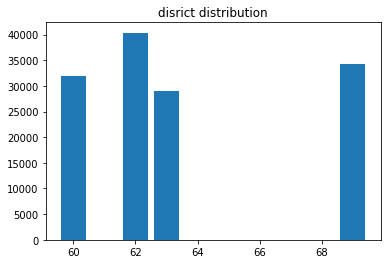

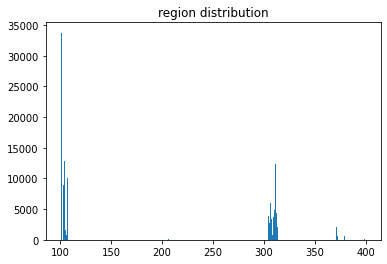

In [ ]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()